# How to Run the Code

## Requirements
To execute this code, ensure you have the following Python libraries installed:
- `numpy`: For numerical computations, including FFT operations.
- `pandas`: For structured data handling and manipulation.
- `matplotlib`: For creating plots and visualizations.
- `scipy`: For curve fitting using optimization tools.

#### The script will generate three plots:
- Improved GPS Motion with Sine Wave Fits: Visualizes raw GPS data and sine wave approximations.
- FFT of GPS Walks: Frequency domain analysis of the GPS motion for all 20 runs.
- Filtered Inverse FFT of Mean Frequency: Reconstructed dominant oscillation from the mean FFT.

#### Bibliography
- https://numpy.org/devdocs/user/index.html#user
- https://numpy.org/doc/stable/reference/routines.fft.html
- https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
- https://pandas.pydata.org/docs/user_guide/index.html#user-guide
- https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/


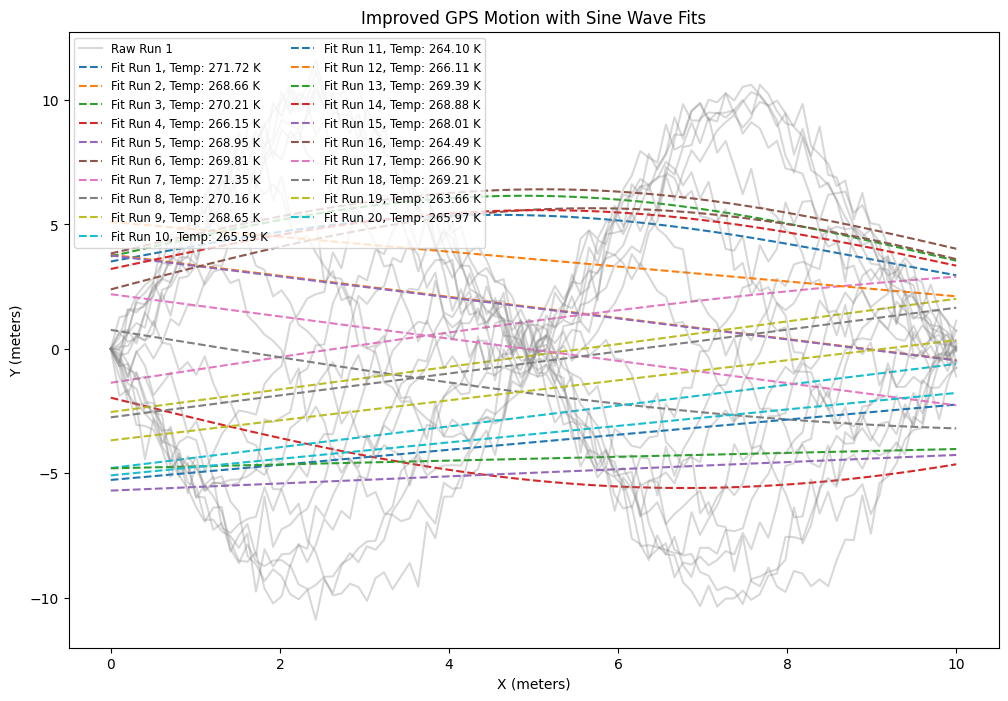

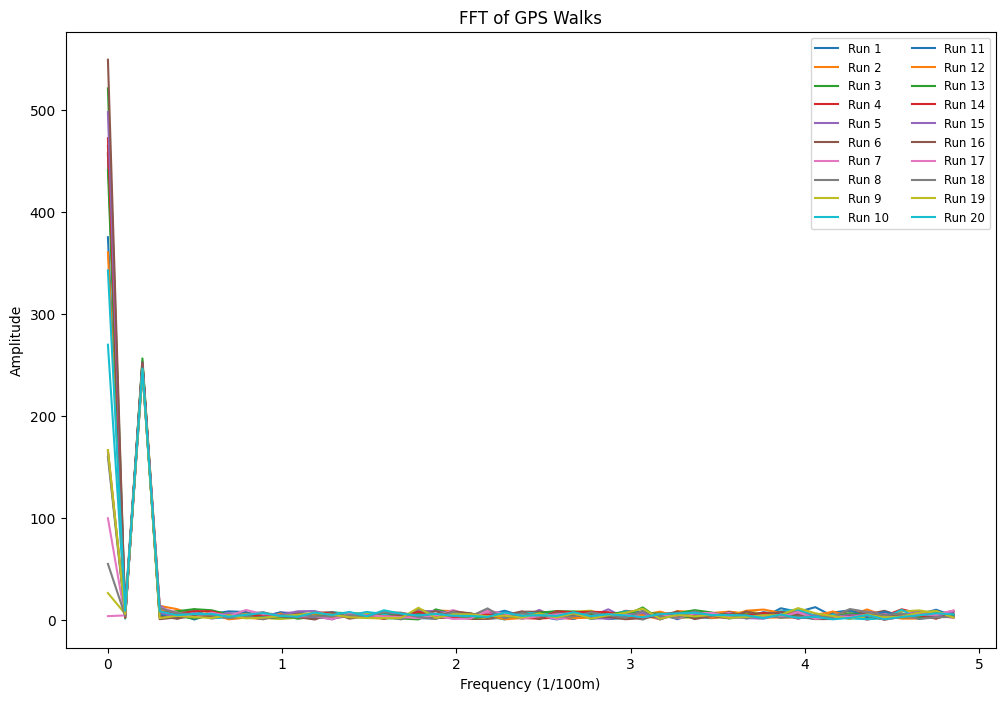

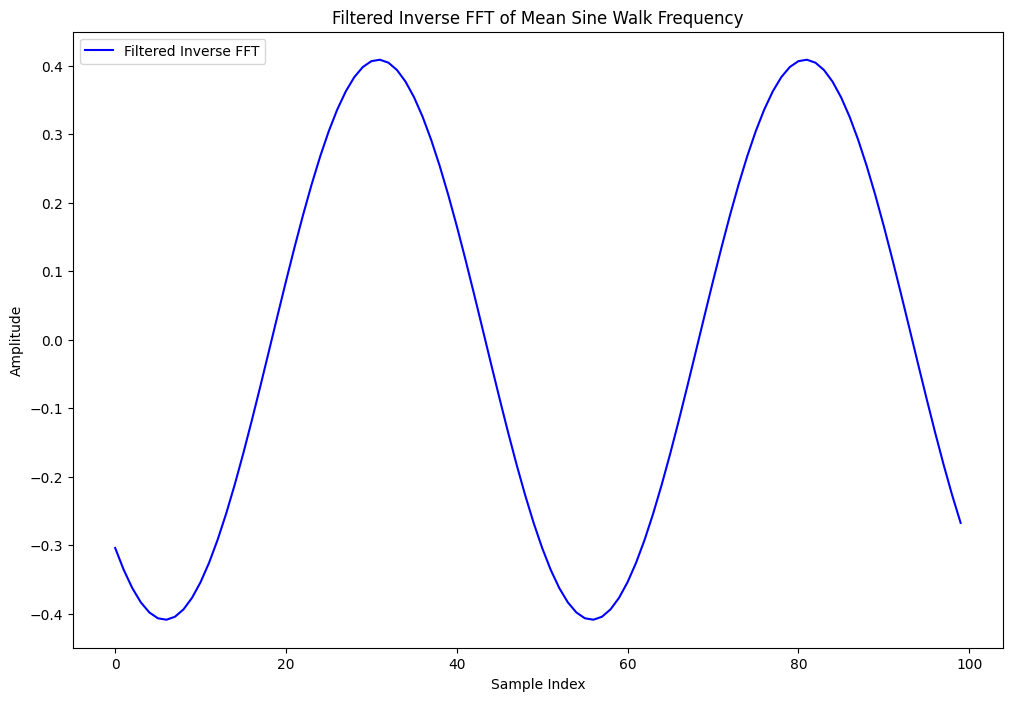

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Sine wave model function
def model_func(x, a, b, c):
    """
    Sine wave model function
    Parameters:
        x (array): Input x-axis data.
        a (float): Amplitude of the sine wave.
        b (float): Frequency of the sine wave.
        c (float): Vertical offset.

    Returns:
        array: Computed sine wave values.
    """
    return a * np.sin(b * x) + c

# Estimate dominant frequency using FFT
def estimate_frequency(x, y, min_freq_threshold=0.1):
    """
    Estimate the dominant frequency in the data using FFT.

    Parameters:
        x (array): Input x-axis data.
        y (array): Input y-axis data.
        min_freq_threshold (float): Minimum valid frequency threshold.

    Returns:
        float: Dominant frequency if above threshold, otherwise None.
    """
    fft_result = np.fft.fft(y - y.mean())  # Remove mean (DC component)
    freq_axis = np.fft.fftfreq(len(x), d=(x[1] - x[0]))  # Frequency axis

    # Only consider positive frequencies
    positive_freqs = freq_axis[:len(freq_axis) // 2]
    amplitudes = np.abs(fft_result[:len(freq_axis) // 2])

    # Find dominant frequency ignoring zero
    dominant_idx = np.argmax(amplitudes[1:]) + 1
    dominant_freq = positive_freqs[dominant_idx]

    # Validate frequency
    if dominant_freq < min_freq_threshold:
        print(f"Warning: Frequency too low ({dominant_freq:.4f}). Using fallback frequency.")
        return None
    return dominant_freq

# Initialize lists to store data and temperatures
all_data = []
all_temperatures = []

# Simulate data for 20 runs
for i in range(1, 21):
    x = np.linspace(0, 10, 100)  # Simulated X-axis (meters)
    y = 5 * np.sin(2 * np.pi * x / 5 + np.random.uniform(0, 2 * np.pi)) + np.random.normal(0, 0.5, len(x))
    all_data.append(pd.DataFrame({'x': x, 'y': y}))
    all_temperatures.append(267.04 + np.random.uniform(-5, 5))  # Simulate slight temperature variation

# Plot the GPS motion with sine wave fits
plt.figure(figsize=(12, 8))
DEFAULT_FREQUENCY = 2 * np.pi / 5  # Fallback frequency

for i, gps_data in enumerate(all_data):
    # Normalize to starting point (origin at 0,0)
    x = gps_data['x'] - gps_data['x'].iloc[0]
    y = gps_data['y'] - gps_data['y'].iloc[0]

    # Estimate frequency
    freq_estimate = estimate_frequency(x, y)
    if freq_estimate is None:
        freq_estimate = DEFAULT_FREQUENCY  # Use fallback frequency

    # Fit sine wave model
    try:
        initial_guess = [np.ptp(y) / 2, freq_estimate, 0.0]  # Amplitude, frequency, offset
        params, _ = curve_fit(model_func, x, y, p0=initial_guess)

        # Generate sine wave
        fitted_y = model_func(x, *params)

        # Debugging: Plot raw data alongside sine fits
        plt.plot(x, y, color='gray', alpha=0.3, label=f"Raw Run {i+1}" if i == 0 else "")
        plt.plot(x, fitted_y, linestyle='--', label=f"Fit Run {i+1}, Temp: {all_temperatures[i]:.2f} K")
    except RuntimeError as e:
        print(f"Run {i+1}: Curve fitting failed ({e}). Using fallback sine wave.")
        fallback_y = model_func(x, np.ptp(y) / 2, DEFAULT_FREQUENCY, 0.0)
        plt.plot(x, fallback_y, linestyle='--', label=f"Fallback Fit Run {i+1}, Temp: {all_temperatures[i]:.2f} K")

# Plot settings
plt.title("Improved GPS Motion with Sine Wave Fits")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.show()

# Function to compute FFT (from the algorithm task)
def compute_fft(y):
    """
    Compute the FFT of the input data.

    Parameters:
        y (array): Input y-axis data.

    Returns:
        array: FFT results.
    """
    return np.fft.fft(y)

# Function to calculate frequency axis in units of 1/100m
def calculate_frequency_axis(sample_spacing, n_points):
    """
    Compute the frequency axis for FFT.

    Parameters:
        sample_spacing (float): Spacing between samples.
        n_points (int): Number of data points.

    Returns:
        array: Frequency axis in units of 1/100 meters.
    """
    return np.fft.fftfreq(n_points, d=sample_spacing)

# Plot FFT for each walk
plt.figure(figsize=(12, 8))

for i, gps_data in enumerate(all_data):
    # Normalize X and Y data
    x = gps_data['x'] - gps_data['x'].iloc[0]
    y = gps_data['y'] - gps_data['y'].iloc[0]
    
    # Compute FFT and frequency axis
    fft_result = compute_fft(y)
    freq_axis = calculate_frequency_axis(sample_spacing=(x[1] - x[0]), n_points=len(x))

    # Only consider positive frequencies
    pos_freqs = freq_axis[:len(freq_axis) // 2]
    amplitudes = np.abs(fft_result[:len(freq_axis) // 2])

    # Plot FFT for each run
    plt.plot(pos_freqs, amplitudes, label=f"Run {i+1}" if i < 20 else None)

# Plot settings
plt.title("FFT of GPS Walks")
plt.xlabel("Frequency (1/100m)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.show()

# Step 1: Preprocess the data and compute FFTs
fft_results = []
min_length = min(len(data['y']) for data in all_data)  # To align all runs

for gps_data in all_data:
    y = gps_data['y'].iloc[:min_length] - gps_data['y'].iloc[:min_length].mean()  # Align and detrend
    fft_results.append(compute_fft(y))

# Step 2: Compute the mean FFT
mean_fft = np.mean(fft_results, axis=0)

# Step 3: Filter the mean FFT (threshold-based filtering)
amplitude_threshold = 5.0  # Set a threshold for filtering
filtered_fft = np.where(np.abs(mean_fft) > amplitude_threshold, mean_fft, 0)

# Step 4: Perform Inverse FFT
filtered_signal = np.fft.ifft(filtered_fft).real  # Take real part of the signal

# Step 5: Plot the filtered signal
plt.figure(figsize=(12, 8))
plt.plot(range(min_length), filtered_signal, label="Filtered Inverse FFT", color='blue')
plt.title("Filtered Inverse FFT of Mean Sine Walk Frequency")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.show()
